In [1]:
from gensim import corpora, models, similarities
import logging
import pprint
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
import ast
import random

In [2]:
dictionary = corpora.Dictionary.load("data/dictionary.dict")

In [3]:
m = models.LdaModel.load("models/lda-10topics.model")
corpus = pd.read_csv("data/corpus_df.csv", index_col=0)
corpus["text_lem"] = corpus["text_lem"].apply(ast.literal_eval)
corpus["text_vec"] = corpus["text_vec"].apply(ast.literal_eval)

In [4]:
for i in range(10):
    print("===",i)
    top = m.get_topic_terms(topicid=i, topn=15)
    for word in top:
        print("\t",dictionary.get(word[0]), word[1])

=== 0
	 operation 0.0137155563137
	 reuters 0.0124741404772
	 health 0.0110496415098
	 capsule 0.0105978127357
	 will 0.0102749567803
	 english 0.0101703638113
	 hand 0.00868012532475
	 2015 0.00768453513904
	 force 0.00703824611199
	 time 0.00687145831691
	 integrity 0.00565995417872
	 interesting 0.00565792821042
	 gu 0.00537168424711
	 hard 0.00505860540343
	 two 0.00504130059894
=== 1
	 will 0.013056254959
	 operation 0.01225257263
	 health 0.012042747972
	 reuters 0.0109139363064
	 english 0.0106431642429
	 capsule 0.00949730787853
	 force 0.00907455261498
	 2015 0.00817796133654
	 hand 0.0079367370009
	 time 0.00689203435557
	 integrity 0.00519428875413
	 two 0.00504270094199
	 interesting 0.00479931252334
	 business 0.00433984278335
	 hard 0.0042053278133
=== 2
	 health 0.01591191029
	 operation 0.0144098738539
	 will 0.012823269746
	 english 0.0115322103665
	 reuters 0.0112654359911
	 force 0.0094144674534
	 hand 0.00898196255557
	 capsule 0.0071628418873
	 2015 0.0061234638040

In [5]:
def applyTopicScores(corpus, trainedModel):
    """
    For a given corpus (that has already been vectorised), create x columns, where ach column is
    the score for a given topic. 
    """
    for i in corpus.index:
        try:
            scores = trainedModel.get_document_topics(corpus.iloc[i]["text_vec"])
            for topic in scores:
                corpus.at[i, "topic_{}_score".format(topic[0])] = topic[1]
        except:
            corpus.drop(i, inplace=True)
            
    return corpus

In [6]:
def getTopicRankings(scoredCorpus):
    """
    For a given SCORED corpus, rank the individual topics by popularity.
    """
    topicCols = [x for x in scoredCorpus if "topic_" in x]
    print("aggregating and ranking {} topic's scores".format(len(topicCols)))
    topicScores = []
    if len(topicCols) == 0:
        print("NO TOPIC SCORES")
        return
    for col in topicCols:
        topicScores.append([col[:-6], np.mean(scoredCorpus[col]), int(col[6:-6])])
        
    topicScores.sort(key=lambda x: x[1], reverse=True)
    return topicScores

In [7]:
def getTopNWords(n, topicNum, model, dictionary):
    """
    Get the top N words from a given topic.
    Returns a list of n * [word, score]
    """
    top = model.get_topic_terms(topicid=topicNum, topn=n)
    newTop = []
    for i in top:
        # Convert to list so we can overwrite
        iList = list(i)
        iList[0] = dictionary.get(iList[0])
        newTop.append(iList)
    return newTop

In [8]:
def getTopicWords(model, scoredCorpus, dictionary, topNTopics):
    topicRankings = getTopicRankings(scoredCorpus)
    
    topicWords = []
    for i in range(topNTopics):
        # Get the number of the topic
        topicN = int(topicRankings[i][0].split("_")[1])
        
        # Get the top words from that topic
        thisTopicWords = getTopNWords(10, topicN, model, dictionary)
        
        # currently just take the top 10 words
        topicWords.append([topicRankings[i][0], [x for x in thisTopicWords]])
    return topicWords
    

In [9]:
def getPopularTopicWords(corpus, model, dictionary, alpha=1):
    
    # Apply the topic scores from the trained model
    scoredCorpus = applyTopicScores(corpus, model)

    topicWords = getTopicWords(m, scoredCorpus, dictionary, 3)
    
    for i in topicWords:
        print(i)
    
getPopularTopicWords(corpus, m, dictionary)

aggregating and ranking 10 topic's scores
['topic_1', [['will', 0.013056254958961426], ['operation', 0.012252572629984864], ['health', 0.012042747971959178], ['reuters', 0.010913936306424905], ['english', 0.010643164242861249], ['capsule', 0.0094973078785310899], ['force', 0.0090745526149765519], ['2015', 0.0081779613365434833], ['hand', 0.0079367370008951079], ['time', 0.0068920343555680186]]]
['topic_9', [['reuters', 0.013386438576220053], ['operation', 0.012359520595505087], ['health', 0.011837904041888845], ['will', 0.01017459467495801], ['force', 0.0096902590003971906], ['english', 0.0093612618857668809], ['time', 0.0083130946136589553], ['2015', 0.0076026287678315208], ['hand', 0.0067927901737888756], ['many', 0.0065010184570367382]]]
['topic_3', [['will', 0.014128626964332902], ['reuters', 0.012444003664009119], ['health', 0.011268663863194838], ['english', 0.0096127264998166727], ['force', 0.0090472161930346597], ['operation', 0.0090314399015617199], ['interesting', 0.007554312

In [136]:
topicWords = getTopicWords(m, scoredCorpus, dictionary, 3)

aggregating and ranking 10 topic's scores


[['that', 1473], ['you', 1339], ['have', 1142], ['your', 954], ['with', 901], ['can', 811], ['on', 787], ['from', 689], ['we', 624], ['this', 613]]
[['your', 1371], ['with', 1247], ['that', 1104], ['or', 1059], ['you', 1027], ['have', 1017], ['can', 868], ['this', 768], ['on', 703], ['i', 687]]
[['you', 1461], ['your', 1265], ['that', 1091], ['have', 1090], ['with', 970], ['from', 737], ['or', 723], ['on', 693], ['can', 675], ['this', 629]]


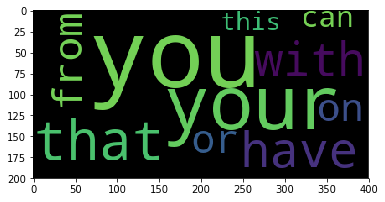

In [240]:
def getWordCloudFromTopicWords(topicWords):
    date = dt.datetime.now()
    dateString = "{}-{}-{}".format(date.day, date.month, date.year)
    
    for top in range(len(topicWords)):
        topicName = topicWords[top][0]
        scaled = topicWords[top][1]

        # Scale the probabilites to a large enough int (simulate a frequency)
        scaled = [[x[0], int(x[1]*100000)] for x in scaled]

        # Store all the mock frequencies in a dict
        freqDict = {}
        for w in scaled:
            freqDict[w[0]] = w[1]

        wc = wordcloud.wordcloud.WordCloud(stopwords = set(["it"])) # placeholder stopword list
        wc.generate_from_frequencies(freqDict)
        
        wc.to_file("wordclouds/{}_{}.jpg".format(topicName, dateString))

In [239]:
!ls -l wordclouds

total 48
-rw-rw-r-- 1 rebootaihk rebootaihk 12608 Aug 14 05:32 topic_0_14-8-2018.jpg
-rw-rw-r-- 1 rebootaihk rebootaihk 13022 Aug 14 05:32 topic_5_14-8-2018.jpg
-rw-rw-r-- 1 rebootaihk rebootaihk 13143 Aug 14 05:32 topic_7_14-8-2018.jpg


In [199]:
"hello "*10

'hello '

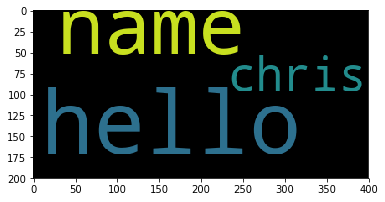

In [153]:
a = wordcloud.wordcloud.WordCloud()

a.generate("hello my name is chris")

a.to_file("test.jpg")

plt.imshow(a)


In [144]:
import wordcloud

In [128]:
wordcloud.wordcloud.

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 'ours',
 '